<a href="https://colab.research.google.com/github/G0rav/image_similarity_search/blob/main/CLIP_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning CLIP model on fashion mnist dataset for classification task and then use embeddings for image similarity

## Installing necessary libraries


In [ ]:
# Installing necessary libraries
!pip install datasets
!pip install torch
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Loading and preparing fashion mnist dataset

In [ ]:
# Importing torch
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import numpy as np

# setting device
# device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Loading and transforming the Fashion MNIST dataset for CLIP compatibility
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels for CLIP
    transforms.Resize((224, 224)),  # Resize to match CLIP input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.15MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.76MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# quick look
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
from torch.utils.data import Subset

# Select a subset of 5000 images for training
train_subset_size = 5000
indices = torch.randperm(len(train_dataset))[:train_subset_size]  # Randomly select 5000 indices
train_subset = Subset(train_dataset, indices)


# Select a subset of 5000 images for training
test_subset_size = 1000
indices1 = torch.randperm(len(test_dataset))[:test_subset_size]  # Randomly select 5000 indices
test_subset = Subset(test_dataset, indices1)

In [ ]:
len(train_subset)

5000

In [ ]:
# DataLoader setup for batching the data for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [ ]:
# Verify dataset and labels shape
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


## Downloading clip base model

In [ ]:
# Loading pre-trained CLIP Model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
# Adding classification layer for Classification
class CLIPFashionMNIST(nn.Module):
    """
    A neural network model combining CLIP features with a classification layer.
    The CLIP model is used to extract visual features, and a fully connected network
    is used to classify Fashion MNIST images.
    """
    def __init__(self, clip_model, num_classes):
        super(CLIPFashionMNIST, self).__init__()
        self.clip = clip_model.vision_model  # Use CLIP's vision model as a feature extractor
        self.fc1 = nn.Linear(clip_model.config.vision_config.hidden_size, 64)  # First hidden layer
        self.batch_norm1 = nn.BatchNorm1d(64)  # Batch Normalization
        self.dropout = nn.Dropout(0.25)  # Dropout with 50% probability
        self.fc2 = nn.Linear(64, num_classes)  # Output layer

    def forward(self, images):
        """
        Forward pass through the model, using the CLIP model for feature extraction
        and additional layers for classification.

        Args:
            images (torch.Tensor): A batch of images to be passed through the model.

        Returns:
            logits (torch.Tensor): Raw class predictions for each image.
        """
        vision_outputs = self.clip(pixel_values=images)  # Extract features using CLIP
        x = self.fc1(vision_outputs.pooler_output)  # Apply first linear layer
        x = torch.relu(x)  # Apply ReLU activation
        x = self.batch_norm1(x)  # Apply batch normalization
        x = self.dropout(x)  # Apply dropout
        logits = self.fc2(x)  # Output logits
        return logits

num_classes = 10  # Fashion MNIST has 10 classes
model = CLIPFashionMNIST(clip_model, num_classes).to(device)

model


CLIPFashionMNIST(
  (clip): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
           

In [ ]:
# Define the loss function and optimizer for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

def train(model, loader, criterion, optimizer):
    """
    Train the model for one epoch on the provided dataloader.

    Args:
        model (torch.nn.Module): The model to train.
        loader (torch.utils.data.DataLoader): DataLoader providing the dataset.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.

    Returns:
        float: The average loss for the epoch.
    """
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
  """
    Evaluate the model's performance on the validation set.

    Args:
        model (torch.nn.Module): The model to evaluate.
        loader (torch.utils.data.DataLoader): DataLoader providing the dataset.
        criterion (torch.nn.Module): The loss function.

    Returns:
        tuple: The average loss and accuracy for the dataset.
    """
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

# Fine-tune
epochs = 1
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = evaluate(model, test_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")


Epoch 1/1: Train Loss = 0.5069, Val Loss = 0.3709, Val Accuracy = 0.8738


## Evaluate

In [ ]:
def extract_embeddings_from_batches(model, dataloader, device, num_batches=5):
    """
    Extract embeddings and labels from a limited number of batches.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): Dataloader for the dataset.
        device (torch.device): Device to run the model on.
        num_batches (int): Number of batches to process.

    Returns:
        tuple: (embeddings, labels) where embeddings is a torch.Tensor of shape
               (num_samples, embedding_dim) and labels is a torch.Tensor of shape (num_samples,)
    """
    model.eval()  # Set the model to evaluation mode
    all_embeddings = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(dataloader, desc="Extracting Embeddings")):
            if i >= num_batches:
                break  # Stop after processing the specified number of batches

            # Move images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # Get embeddings from the model
            vision_outputs = model.clip(pixel_values=images)
            embeddings = vision_outputs.pooler_output

            # Collect embeddings and labels
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())
            all_images.append(images.cpu())

    # Stack all embeddings and labels
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_images = torch.cat(all_images, dim=0)

    return all_embeddings, all_labels, all_images

# Example Usage:
# Assuming `model` is your trained model and `test_loader` is the DataLoader for the evaluation dataset.
all_embeddings, all_labels, all_images = extract_embeddings_from_batches(model, test_loader, device, num_batches=5)

print(f"Extracted Embeddings Shape: {all_embeddings.shape}")
print(f"Extracted Labels Shape: {all_labels.shape}")
print(f"Extracted Images Shape: {all_images.shape}")


Extracting Embeddings:   2%|▏         | 5/313 [00:00<00:55,  5.51it/s]

Extracted Embeddings Shape: torch.Size([160, 768])
Extracted Labels Shape: torch.Size([160])
Extracted Images Shape: torch.Size([160, 3, 224, 224])


In [ ]:
# checking embeddings
all_embeddings

tensor([[ 0.2771, -0.7779, -0.3509,  ..., -1.1689, -0.6401, -0.1299],
        [ 1.0143, -1.0580, -0.4906,  ..., -1.7902,  0.2806,  0.9740],
        [ 0.4665, -0.8411, -0.3430,  ..., -1.1542, -0.5233, -0.2330],
        ...,
        [ 0.4459, -0.5332, -0.3716,  ..., -0.8003, -0.9654, -0.0300],
        [ 0.8609, -0.8210, -0.1378,  ..., -1.0996,  0.2027,  1.3135],
        [ 1.7976, -0.8623, -0.4454,  ..., -1.3230, -0.4928,  0.2902]])

In [ ]:
def calculate_metrics(query_idx, all_embeddings, labels, top_k=5):
    """
    Calculate precision, recall, and retrieval accuracy for image similarity search.
    """
    # Normalize embeddings for cosine similarity
    all_embeddings = torch.nn.functional.normalize(all_embeddings, p=2, dim=1)
    query_embedding = all_embeddings[query_idx].unsqueeze(0)

    # Get similarities and exclude query index
    similarities = (all_embeddings @ query_embedding.T).squeeze(1).cpu().numpy()
    similarities[query_idx] = -np.inf  # Exclude query image
    top_indices = np.argsort(similarities)[::-1][:top_k]  # Top k most similar indices

    # Convert labels to numpy array
    labels_np = labels.cpu().numpy() if torch.is_tensor(labels) else np.array(labels)

    # Get predicted labels and calculate relevant items
    predicted_labels = labels_np[top_indices]
    query_label = labels_np[query_idx]
    relevant_items = np.sum(predicted_labels == query_label)
    total_relevant = np.sum(labels_np == query_label) - 1  # Exclude query image

    # Calculate precision, recall, and retrieval accuracy
    precision = relevant_items / top_k
    recall = relevant_items / total_relevant if total_relevant > 0 else 0
    retrieval_accuracy = 1.0 if relevant_items > 0 else 0.0

    return {
        'precision': precision,
        'recall': recall,
        'retrieval_accuracy': retrieval_accuracy
    }

def evaluate_model(all_embeddings, labels, num_samples=100, top_k=5):
    """
    Evaluate model performance across multiple queries.
    """
    # Randomly sample query indices
    indices = np.random.choice(len(labels), size=min(num_samples, len(labels)), replace=False)

    # Initialize metrics
    total_precision, total_recall, total_retrieval_accuracy = 0, 0, 0

    # Evaluate metrics for each sampled query
    for idx in indices:
        metrics = calculate_metrics(idx, all_embeddings, labels, top_k)
        total_precision += metrics['precision']
        total_recall += metrics['recall']
        total_retrieval_accuracy += metrics['retrieval_accuracy']

    # Average the metrics
    avg_metrics = {
        'avg_precision': total_precision / len(indices),
        'avg_recall': total_recall / len(indices),
        'avg_retrieval_accuracy': total_retrieval_accuracy / len(indices)
    }

    return avg_metrics

# Evaluate the model
evaluation_results = evaluate_model(all_embeddings, all_labels, num_samples=50, top_k=10)

print("\nModel Evaluation Results:")
print(f"Average Precision: {evaluation_results['avg_precision']:.4f}")
print(f"Average Recall: {evaluation_results['avg_recall']:.4f}")
print(f"Average Retrieval Accuracy: {evaluation_results['avg_retrieval_accuracy']:.4f}")



Model Evaluation Results:
Average Precision: 0.7360
Average Recall: 0.4672
Average Retrieval Accuracy: 0.9600


## Extract similar images for query image

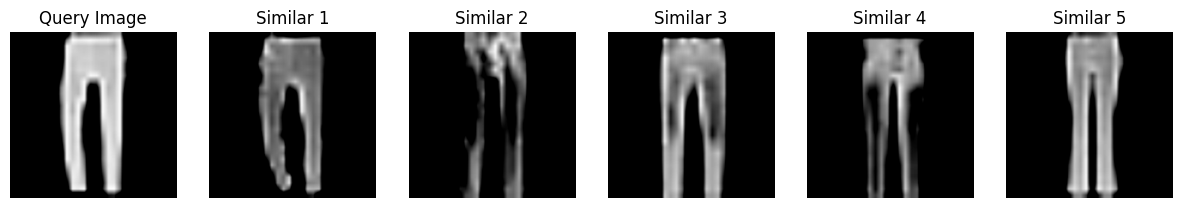

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def plot_similar_images(query_idx, all_embeddings, all_images, top_k=5):
    """
    Find and display the most similar images to a query image based on CLIP embeddings.

    Args:
        query_idx (int): Index of the query image in the extracted images and embeddings.
        all_embeddings (torch.Tensor): Normalized embeddings of all images.
        all_images (torch.Tensor): Tensor of all images (C, H, W format).
        top_k (int): Number of similar images to display.

    Returns:
        None
    """
    # Ensure embeddings are normalized for cosine similarity
    normalized_embeddings = F.normalize(all_embeddings, p=2, dim=1)

    # Get the embedding of the query image
    query_embedding = normalized_embeddings[query_idx].unsqueeze(0)

    # Compute cosine similarities between the query embedding and all embeddings
    similarities = (normalized_embeddings @ query_embedding.T).squeeze(1).cpu().numpy()

    # Get indices of the top-k most similar images
    top_indices = np.argsort(similarities)[::-1][:top_k + 1]  # +1 to include the query image

    # Plot the query image and its most similar images
    plt.figure(figsize=(15, 3))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(all_images[query_idx].permute(1, 2, 0).numpy(), cmap="gray")
    plt.title("Query Image")
    plt.axis("off")

    for i, idx in enumerate(top_indices[1:]):  # Skip the query image itself
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(all_images[idx].permute(1, 2, 0).numpy(), cmap="gray")
        plt.title(f"Similar {i+1}")
        plt.axis("off")

    plt.show()

# Example Usage:
query_idx = 1  # Index of the query image
plot_similar_images(query_idx, all_embeddings, all_images, top_k=5)
